# Simulating neural computation with Brian 2
## Preliminary remarks: the jupyter notebook
The [jupyter notebook](http://jupyter.readthedocs.io/) is a tool to mix text, code, and results/figures generated by the code in a single document that can be shared and remains editable.

We here use it with Python, but support for other programming languages exists.

Code written in a cell will be executed when you press `Ctrl+Enter` or `Shift+Enter` (this will also jump to the next code cell, or open a new code cell if none exists):

In [1]:
3 + 4 -3

4

In [2]:
6 * 4

24

In [3]:
x = 7

Note that cells can be executed in arbitrary order, which can potentially get confusing. E.g. changing the value of `x` above after executing the cell below will make the two cells inconsistent. You can determine the order of evaluations by looking at the number in square brackets in front of each cell. However, this is not foolprof, e.g. if you change the content of a cell without re-executing it, the number does not change. To make sure that a document does not have any such oddities in it, you can run it from scratch by chosing `Kernel --> Restart & Run All` in the menu.

In [4]:
x + 4

11

Text can be formatted using the light-way formatting language [markdown](https://daringfireball.net/projects/markdown/syntax). You can have for example text in *italics* or **bold**. It also allows you to write mathematical expressions using LaTeX syntax: $\sqrt 2$ (double click a formatted cell to see its "source code")

## Using Brian – Neuron models
Let's import "everything" from the Brian 2 package.

This also provides access to the scientific computing package [numpy](http://www.numpy.org/) (imported as `np`), and to the package `pyplot` from the plotting library [matplotlib](http://matplotlib.org) (imported as `plt`).

We also ask the notebook to include plots directly in the notebook (instead of showing them in a separate window). Note that lines starting with `%` are specific commands for the jupyter notebook, they won't work in a Python script, for example. (We use this specific command here because the matplotlib version installed on the machines in the computer room is quite old. In general, a better choice is `%matplotlib notebook` which enables plots that are zoomable, etc.)

We also switch off Brian's "code generation" mechanism, which improves the performance for complex models by generating/compiling/executing C++ code "behind the scenes". For the simple models that we are covering in this tutorial, this is not necessary – it even slows down things due to the need for compilation.

In [5]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = 'numpy'

Let's start using Brian! Brian provides a system for physical units:

In [6]:
Rm = 1*Mohm
I = 50*nA

Operations with physical quantities lead to new quantities with potentially different units:

In [7]:
I*1000

50. * uamp

In [8]:
Rm * I

50. * mvolt

Brian will complain if operations do not make sense:

In [9]:
Rm + I

DimensionMismatchError: Cannot calculate 1. Mohm + 50. nA, units do not match (units are ohm and amp).

(Python error messages are very verbose: have a look at the *end* of the error message first!)

Let's define a simplified integrate-and-fire model (everything has been multiplied by the membrane resistance $R_m$, so the right-hand side is not divided by $C_m$, but instead by $\tau_m = R_m C_m$): 

In [10]:
tau_m = 5*ms
V_r = -70*mV
eqs = 'dV/dt = (V_r - V)/tau_m : volt'
neurons = NeuronGroup(1, eqs)
neurons.V = -65*mV

In [11]:
run(10*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.07s). [brian2.stateupdaters.base.method_choice]


(Let's ignore the warning for now).

After 10 ms, the membrane potential should have relaxed towards the resting potential $V_r$:

In [12]:
neurons.V

<neurongroup.V: array([-69.32332358]) * mvolt>

If we want to look at the development of the membrane potential over time, we'll have to tell Brian to record the values of `V` during the simulation:

In [13]:
tau_m = 5*ms
V_r = -70*mV
eqs = 'dV/dt = (V_r - V)/tau_m : volt'
neurons = NeuronGroup(1, eqs)
neurons.V = -65*mV

monitor = StateMonitor(neurons, 'V', record=0)  # Record neuron with index 0 (indices start with 0 in Python)

In [14]:
run(10*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


Now we can plot the values using Python's plotting library. Note that we divide the physical quantitities by the scale we are interested in to get values "in ms" or "in mV":

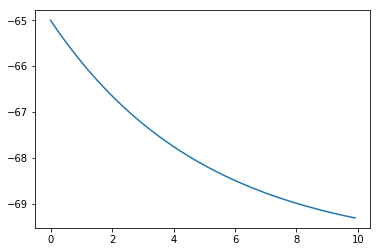

In [15]:
plt.plot(monitor.t/ms, monitor.V[0]/mV)

To get rid of the distracting "Out" line, we can add a semicolon at the end of the line (something that is only relevant to the last line of a code cell when running things in an interactive environment like the jupyter notebook -- you *don't* have to add a semicolon to every line!).

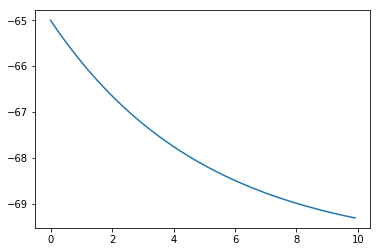

In [16]:
plt.plot(monitor.t/ms, monitor.V[0]/mV);

From now on, we'll add call to `start_scope()` at the beginning of each new model. `start_scope` is a Brian function that is only needed when executing many models in a jupyter notebook. It tells Brian to forget about all previous simulations. This is not necessary all the time, e.g. in the following code blocks we will overwrite the neurons variable, therefore there is no ambiguity as to which model should be simulated. As soon as models get more complex and have multiple components, it can become messy otherwise.

Constants defined outside of the equations (e.g. $\tau_m$ in our case) are the same for all neurons in a group. If we want to have neuron-specific values, we'll have to include them in the equations. We do this for a constant current input $I_e$ that can have differing strengths for each neuron (note that this "current" has units of voltage, because of our "everything multiplied by $R_m$" formulation of the integrate-and-fire model).

When setting initial conditions, we can provide a string that defines a mathematical expression to be evaluated for each neuron. In it we can refer to constants and neuronal state variables, as well as to a few predefined variables and functions such as `rand()` to give a uniformly distributed random number between 0 and 1.

In [17]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, eqs)
neurons.V = -65*mV
neurons.I_e = 'rand()*50*mV'
monitor = StateMonitor(neurons, 'V', record=True)

In [18]:
run(10*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


To plot the voltages of all 10 neurons at once, we can plot `monitor.V` (instead of `monitor.V[0]` etc.). However, matplotlib wants the first dimension (i.e., the number of rows) of `monitor.V` to be the same as the dimension of `monitor.t`, but the first dimension of `monitor.V` is the neuron index in Brian. We therefore have to transpose the matrix, i.e. use `monitor.V.T`:

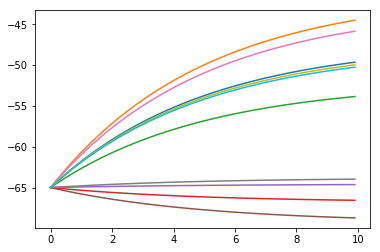

In [19]:
plt.plot(monitor.t/ms, monitor.V.T/mV);

In [20]:
neurons.V

<neurongroup.V: array([-49.59593335, -44.44262488, -53.81795022, -66.55934633,
       -64.6311033 , -68.72526416, -45.7951922 , -63.96257763,
       -49.92028992, -50.21148356]) * mvolt>

Our neuron does not emit any spikes yet. To make it into an actual integrate-**and-fire** neuron, we have to define a "threshold condition" (when does the neuron emit a spike?) and a "reset statement" (what should the neuron do after a spike was emitted?).
We also introduce a new monitor, a `SpikeMonitor` that only records the spiking activity the cells, i.e. the time of spikes and the index of the neuron that emitted it.

In [21]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV
neurons.I_e = 'rand()*50*mV'
monitor = StateMonitor(neurons, 'V', record=True)
spike_mon = SpikeMonitor(neurons)

In [22]:
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


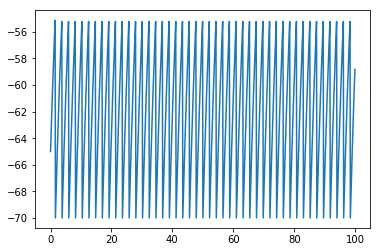

In [23]:
plt.plot(monitor.t/ms, monitor.V[0]/mV);

(Note that for a visualization in a paper, you'd probably add a vertical line for each spike to make the membrane potential look "more realistic")

If we plot the indices of the neurons that spiked against the time of the spike, we get a classical "raster plot":

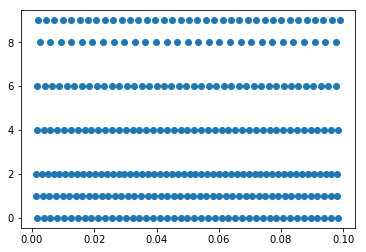

In [24]:
plt.plot(spike_mon.t, spike_mon.i, 'o');

## ----- Refractoriness (we did not have time to cover this in the course) -----

In the above model, each neurons can fire action potentials at basically arbitrarily high rates for sufficiently strong input currents. Real neurons, however, have a period – called the refractory period – after each spike during which it cannot fire action potentials. For this, Brian offers the `refractory` keyword argument:

In [25]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'rand()*50*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [26]:
run(10*ms)

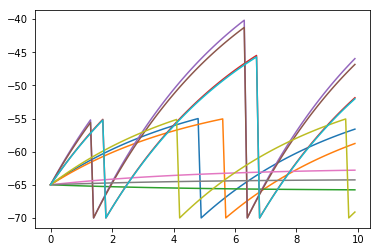

In [27]:
plt.plot(monitor.t/ms, monitor.V.T/mV);

This is not quite what want, though: the neuron cannot spike, but its membrane potential continues to update according to its differential equation, going far beyond the threshold! Instead, we'd like to clamp the membrane potential to the reset potential during the refractory. We can do this in Brian by declaring that $V$ should follow the differential equation, except during the refractory period:

In [28]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'rand()*50*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [29]:
run(10*ms)

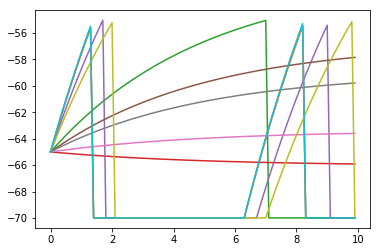

In [30]:
plt.plot(monitor.t/ms, monitor.V.T/mV);

## ---- End of refractoriness  ---- 

## Using Brian – Synapse models

The "input" our cell received in the previous model was a constant current input. While we can inject constant currents into neurons during an experiment, the membrane potential of neurons under normal conditions is mostly affect by the temporary currents arising from the impact of chemical synapses. As a first step towards modeling such synapses, we make our current temporary (decaying explonentionally to zero). We'll also record the evolution of this current over time by including it in our `StateMonitor`:

In [31]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV
neurons.I_e = 'rand()*50*mV'
monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
spike_mon = SpikeMonitor(neurons)

In [32]:
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.38s). [brian2.stateupdaters.base.method_choice]


We'll use the `subplots` function to create two rows (and one colum) of plots, the ax variable is now a list of two axes that we can index with `[..]` (remember that indices in Python start at 0):

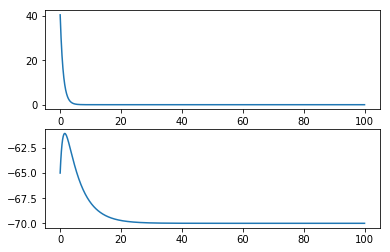

In [33]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(monitor.t/ms, monitor.I_e[0]/mV);
ax[1].plot(monitor.t/ms, monitor.V[0]/mV);

Let's leave aside our neural model for a moment and look at other ways to generate spikes, useful to serve as input to a network of neurons. We'll first have a look at a SpikeGeneratorGroup which can be used to emit a pre-defined pattern of spikes. To check whether it does the right thing, we record these spikes using a SpikeMonitor. For example, let's define a group of 3 "neurons" that spikes at 2ms, 4ms, and 6ms, respectively, and the second neuron (index 1), spiking again at 8ms and 9ms.

In [34]:
start_scope()

spikes = SpikeGeneratorGroup(3, [0, 1, 2, 1, 1],
                                [2, 4, 6, 8, 9]*ms)
spike_mon = SpikeMonitor(spikes)

In [35]:
run(10*ms)

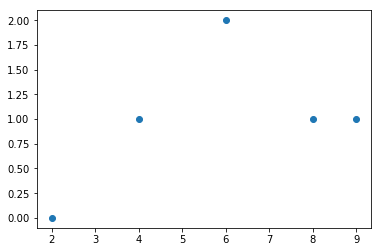

In [36]:
plt.plot(spike_mon.t/ms, spike_mon.i, 'o');

Repeated spike patterns can be generated using the `period` argument:

In [37]:
start_scope()

spikes = SpikeGeneratorGroup(3, [0, 1, 2, 1, 1],
                                [2, 4, 6, 8, 9]*ms,
                             period=10*ms)
spike_mon = SpikeMonitor(spikes)

In [38]:
run(100*ms)

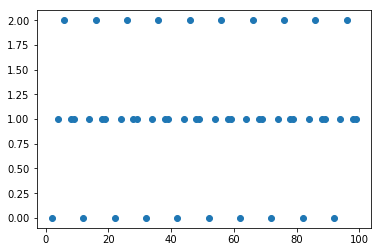

In [39]:
plt.plot(spike_mon.t/ms, spike_mon.i, 'o');

Another useful way of generating inputs is the `PoissonGroup`, which generates spikes generated by a Poisson process. You can provide individual firing rates for each neuron, or a single firing rate for all neurons:

In [40]:
start_scope()

spikes = PoissonGroup(3, rates=[500, 100, 25]*Hz)
spike_mon = SpikeMonitor(spikes)

In [41]:
run(500*ms)

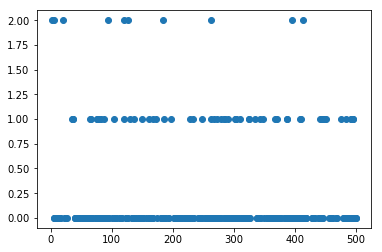

In [42]:
plt.plot(spike_mon.t/ms, spike_mon.i, 'o');

We are now going to connect this source of spikes to our neuron model defined previously. We do this using the `Synapses` class which in addition to the source and target groups, requires us to specify the action that the arrival of a presynaptic spike (hence: `on_pre`) causes. Creating such a `Synapses` object will not yet create synapses (there are many ways in which you could connect two groups), we will have to call the `connect` function to do this. Calling `connect()` without any arguments means: "connect everything in the source group to everything in the target group" (i.e., "all-to-all"):

In [43]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV

spikes = PoissonGroup(1, rates=100*Hz)
synapses = Synapses(spikes, neurons, '',
                    on_pre='I_e_post += 1*mV')
synapses.connect()

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
inp_mon = SpikeMonitor(spikes)
spike_mon = SpikeMonitor(neurons)

In [44]:
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.32s). [brian2.stateupdaters.base.method_choice]


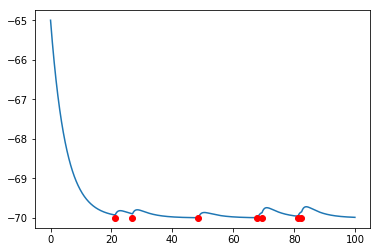

In [45]:
plt.plot(monitor.t/ms, monitor.V[1]/mV)
plt.plot(inp_mon.t/ms,
         np.ones(inp_mon.num_spikes)*-70,
         'ro');

We plotted the activity of all 10 neurons, but they all do the same thing. This is not surprising since they receive the same input from the same Poisson spike sources and all synapses have the same strength. If instead we want to have individual synaptic weights for each connection, we need to include the weight in the synaptic equations (similar to the constant current $I_e$ in the neuronal equations in the very beginning). We'll initialize these weights randomly by using the `rand()` function provided by Brian:

In [46]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV

spikes = PoissonGroup(1, rates=100*Hz)
synapses = Synapses(spikes, neurons, 'weight : volt',
                    on_pre='I_e_post += weight')
synapses.connect()
synapses.weight = 'rand()*10*mV'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
inp_mon = SpikeMonitor(spikes)
spike_mon = SpikeMonitor(neurons)

In [47]:
run(100*ms)

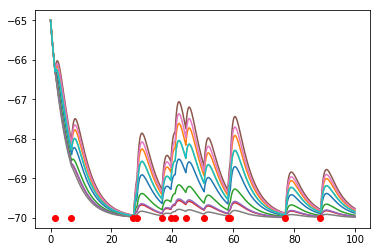

In [48]:
plt.plot(monitor.t/ms, monitor.V.T/mV)
plt.plot(inp_mon.t/ms,
         np.ones(inp_mon.num_spikes)*-70,
         'ro');

Synaptic models can of course be much more complex to what we used above. In particular, the weight does not have to be  a static value, but can change over the course of the simulation. This can be used to model all kinds of plasticity, both short-term and long-term plasticity.

Let's implement a simple model of short-term plasticity:
1. for each spike, the weight is reduced by 10%.
2. In between spikes, the weight relaxes back to its full value with time constant $\tau_w$

(Note that this is not a great model, normally one would rather use something like the [Tsodyks-Markram model](http://www.scholarpedia.org/article/Short-term_synaptic_plasticity)):

In [49]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV

spikes = PoissonGroup(1, rates=100*Hz)
tau_w = 50*ms
synapses = Synapses(spikes, neurons,
                    '''dw/dt = (w0 - w)/tau_w : volt
                       w0 : volt''',
                    on_pre='''I_e_post += w
                              w *= 0.9''')
synapses.connect()
synapses.w0 = 'rand()*10*mV'
synapses.w = 'w0'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
inp_mon = SpikeMonitor(spikes)
spike_mon = SpikeMonitor(neurons)

INFO       The synaptic equation for the variable w does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


(ignore the INFO messages about "clock-driven" for now)

In [50]:
run(100*ms)

INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]


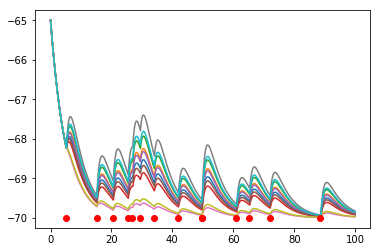

In [51]:
plt.plot(monitor.t/ms, monitor.V.T/mV)
plt.plot(inp_mon.t/ms,
         np.ones(inp_mon.num_spikes)*-70,
         'ro');

Some remarks about the info message about the "clock-driven" calculation of pre_trace and post_trace: large networks of neurons will have many synapses and the calculations that need to be done "per synapse" quickly dominate the total simulation time. By default, Brian uses a "clock-driven" approach to simulate differential equations, i.e. the state variables are updated every time step according to the differential equations. However, we don't actually need all the intermediate values of the traces, we only need their values whenever a pre- or post-synaptic spike arrives. Luckily, the differential equations governing their evolution are very simple (exponential decay) and we can solve them analytically. This means, instead of updating them every time step, we can update them only whenever a spike pre- or post-synaptic to the given synapse occured, calculating the effect of the exponential decay based on the time since the last update. Brian can do this calculation for us, all that is needed to mark the equations as "event-driven":

In [52]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV

spikes = PoissonGroup(1, rates=100*Hz)
tau_w = 50*ms
synapses = Synapses(spikes, neurons,
                    '''dw/dt = (w0 - w)/tau_w : volt (event-driven)
                       w0 : volt''',
                    on_pre='''I_e_post += w
                              w *= 0.9''')
synapses.connect()
synapses.w0 = 'rand()*10*mV'
synapses.w = 'w0'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
inp_mon = SpikeMonitor(spikes)
spike_mon = SpikeMonitor(neurons)

In [53]:
run(100*ms)

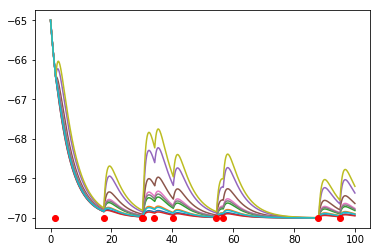

In [54]:
plt.plot(monitor.t/ms, monitor.V.T/mV)
plt.plot(inp_mon.t/ms,
         np.ones(inp_mon.num_spikes)*-70,
         'ro');

Let's also get rid of the information about the integration algorithm: Brian emits this message because we did not explicitly say how the equations should be integrated. In this case, Brian decides which integration algorithm to use and tells us about its choice. In our case, the equations are simple enough to be solved analytically, we therefore chose the method `'exact'` (other options would be for example `'euler'` to integrate with the --fast but not accurate-- forward Euler, or `'rk4'` to integrate with a fourth-order Runge-Kutta method):

In [55]:
start_scope()
tau_m = 5*ms
tau_e = 1*ms
V_r = -70*mV
eqs = '''dV/dt = (V_r - V + I_e)/tau_m : volt
         dI_e/dt = -I_e/tau_e: volt'''
neurons = NeuronGroup(10, eqs, threshold='V > -55*mV',
                      reset='V = V_r')
neurons.V = -65*mV

spikes = PoissonGroup(1, rates=100*Hz)
tau_w = 50*ms
synapses = Synapses(spikes, neurons,
                    '''dw/dt = (w0 - w)/tau_w : volt (event-driven)
                       w0 : volt''',
                    on_pre='''I_e_post += w
                              w *= 0.9''')
synapses.connect()
synapses.w0 = 'rand()*10*mV'
synapses.w = 'w0'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)
inp_mon = SpikeMonitor(spikes)
spike_mon = SpikeMonitor(neurons)

In [56]:
run(100*ms)

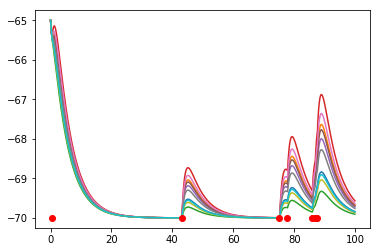

In [57]:
plt.plot(monitor.t/ms, monitor.V.T/mV)
plt.plot(inp_mon.t/ms,
         np.ones(inp_mon.num_spikes)*-70,
         'ro');